In [25]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10, num_negative_samples=1,
                 sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

In [37]:
model.eval()
z = model(torch.arange(data.num_nodes, device=device))

Epoch: 01, Loss: 8.0782, Acc: 0.1460
Epoch: 02, Loss: 6.0507, Acc: 0.1720
Epoch: 03, Loss: 4.9247, Acc: 0.2040
Epoch: 04, Loss: 4.0898, Acc: 0.2360
Epoch: 05, Loss: 3.4560, Acc: 0.2780
Epoch: 06, Loss: 2.9234, Acc: 0.3180
Epoch: 07, Loss: 2.5197, Acc: 0.3480
Epoch: 08, Loss: 2.1974, Acc: 0.3800
Epoch: 09, Loss: 1.9377, Acc: 0.4130
Epoch: 10, Loss: 1.7246, Acc: 0.4420
Epoch: 11, Loss: 1.5518, Acc: 0.4630
Epoch: 12, Loss: 1.4189, Acc: 0.4890
Epoch: 13, Loss: 1.3096, Acc: 0.5080
Epoch: 14, Loss: 1.2233, Acc: 0.5240
Epoch: 15, Loss: 1.1537, Acc: 0.5370
Epoch: 16, Loss: 1.0977, Acc: 0.5490
Epoch: 17, Loss: 1.0543, Acc: 0.5640
Epoch: 18, Loss: 1.0186, Acc: 0.5780
Epoch: 19, Loss: 0.9890, Acc: 0.5950


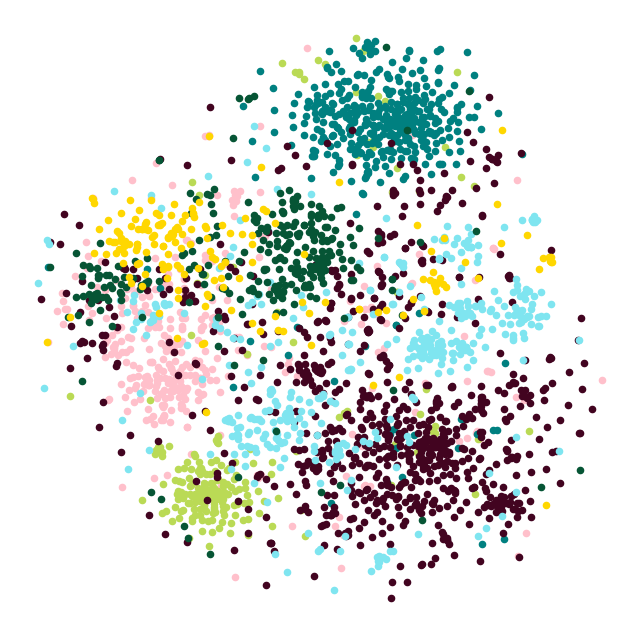

In [3]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc


for epoch in range(1, 20):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)


In [7]:
len(model(torch.tensor([0,], device=device))[0])

128

In [ ]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

In [2]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [8]:
sum(data.val_mask)

tensor(500)

In [9]:
sum(data.train_mask)

tensor(140)

In [10]:
sum(data.test_mask)

tensor(1000)

In [16]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [22]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
data.num_edges

10556

In [16]:
z = model()
model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)

0.595

In [21]:
z[data.test_mask].shape

torch.Size([1000, 128])

In [24]:
model.eval()
out = model(data.x.to(torch.float), data.edge_index, data.batch)

TypeError: Node2Vec.forward() takes from 1 to 2 positional arguments but 4 were given